In [163]:
import numpy as np
from scipy.linalg import toeplitz
from qiskit import transpile
from qsextra import ExcitonicSystem
from jqme.qcomo import qevolve

epsilon = [1, 2]
J = toeplitz([0., 1.])
dt = 0.01
time = np.arange(0, 5, dt)
gamma = 0.1

esys = ExcitonicSystem(energies=epsilon, couplings=J)
esys.set_state(state_type='localized excitation', state=0)

In [164]:
def Trotter_circuit(esys, dt):
    circuit = qevolve(esys,
                      np.arange(0, dt*2, dt),
                      dt=dt,
                      initialize_circuit=False,
                      coll_rates=0.1,
                      verbose=False,
                      )
    qc_decomposed = transpile(circuit[1],
                              basis_gates=['cx', 'rx', 'rz', 'ry',
                                           'x', 'y', 'z', 'h'],
                              )
    return qc_decomposed

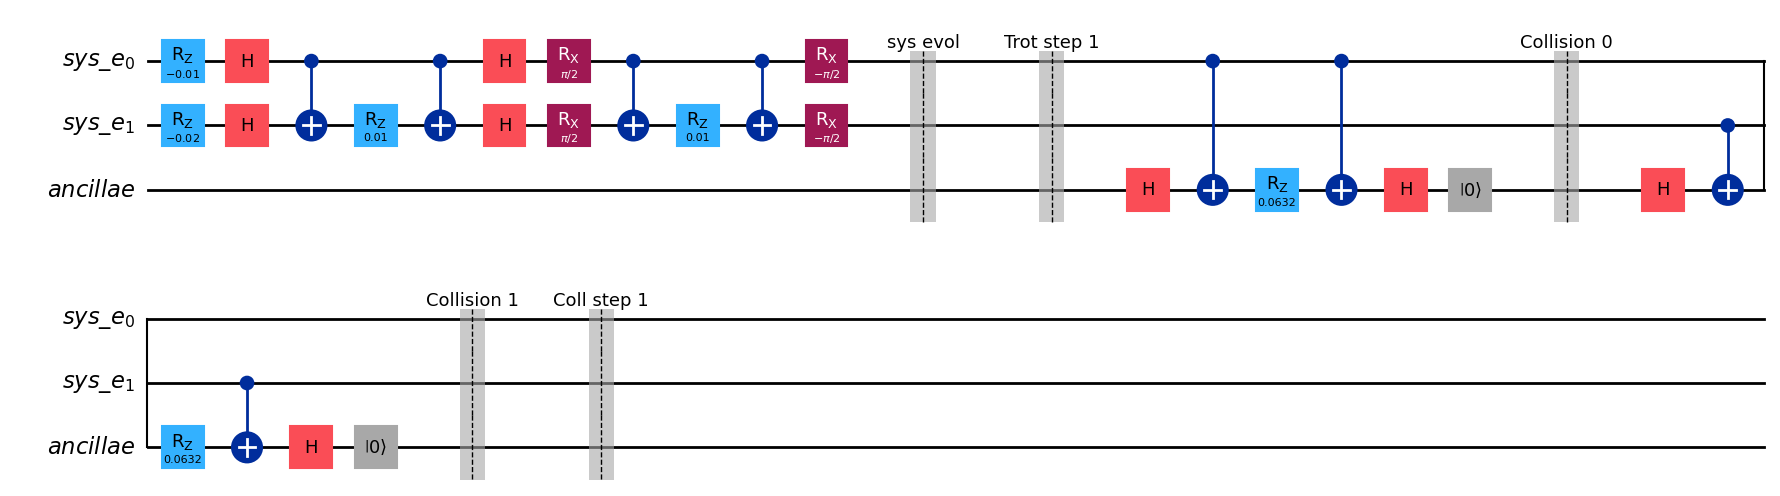

In [165]:
trotter_circuit = Trotter_circuit(esys, dt)
trotter_circuit.draw('mpl')

Start creating the circuits...
Circuits created...


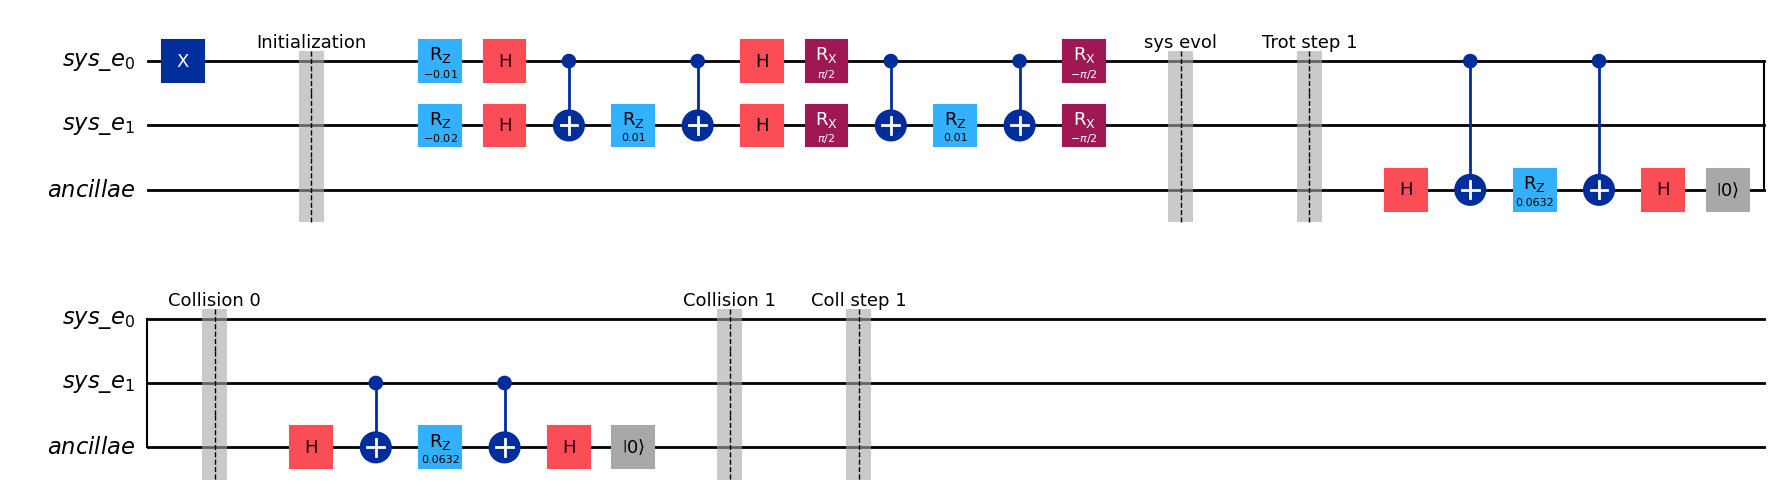

In [166]:
result = qevolve(esys,
                 time,
                 dt=dt,
                 coll_rates=gamma,
                 )

qc_decomposed = transpile(result[1],
                          basis_gates=['cx', 'rx', 'rz', 'ry',
                                       'x', 'y', 'z', 'h'],
                          )

qc_decomposed.draw('mpl')

In [167]:
from qiskit.quantum_info import Statevector

num_args = range(len(epsilon))
sv = Statevector.from_instruction(result[10])
p1 = sv.probabilities(qargs=num_args)

print(p1)

p1_dict = sv.probabilities_dict(qargs=num_args)
print(p1_dict)

[0.         0.99004151 0.00995849 0.        ]
{'01': 0.9900415140224428, '10': 0.00995848597755715}


{'01': 0.9900415140224428, '10': 0.00995848597755715}


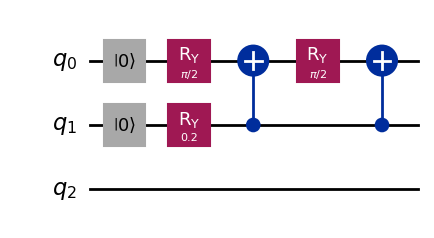

In [168]:
from qiskit import QuantumCircuit

coeff = np.sqrt(p1)

qc = QuantumCircuit(len(epsilon)+1)
qc.initialize(coeff, num_args)

sv = Statevector.from_instruction(qc)
p2 = sv.probabilities_dict(qargs=num_args)

print(p2)

qc_decomposed = transpile(qc,
                          basis_gates=['cx', 'rx', 'rz', 'ry',
                                       'x', 'y', 'z', 'h'],
                          )

qc_decomposed.draw('mpl')

{'00': 1.1231331304592602e-32, '01': 0.9899236518251764, '10': 0.010076348174823673, '11': 3.4969546343742073e-33}


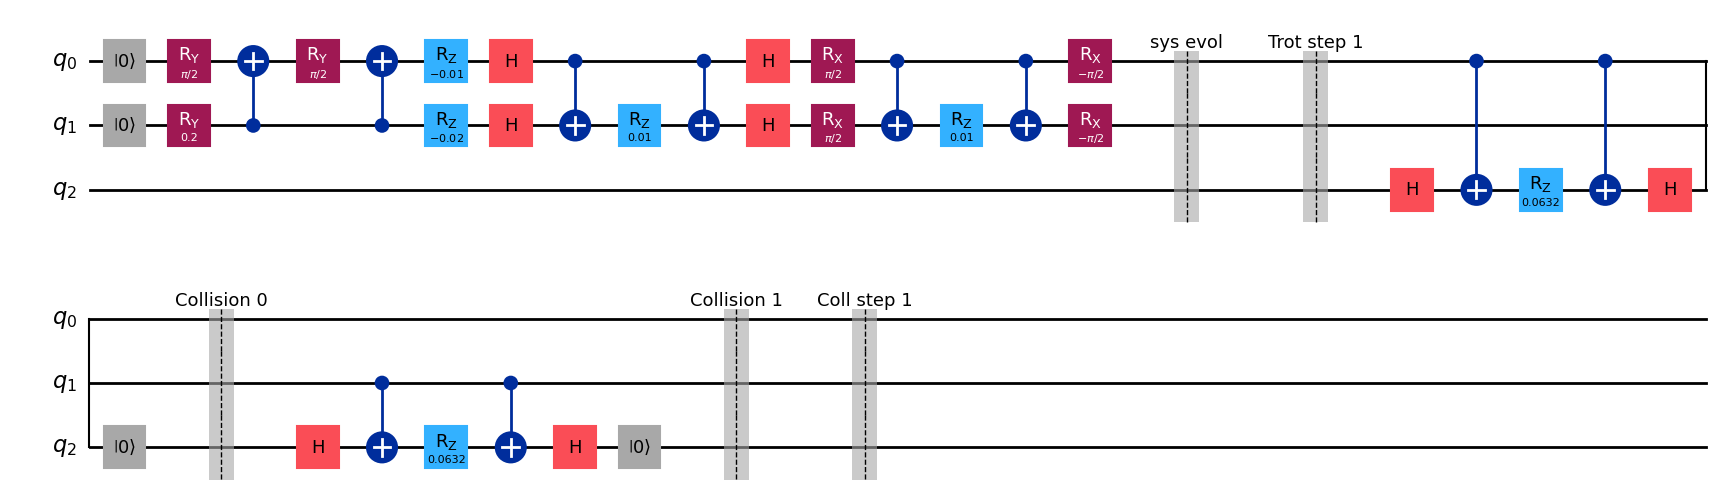

In [169]:
qc_dt = qc.compose(trotter_circuit)

sv = Statevector.from_instruction(qc_dt)
p3 = sv.probabilities_dict(qargs=num_args)

print(p3)

qc_decomposed = transpile(qc_dt,
                          basis_gates=['cx', 'rx', 'rz', 'ry',
                                       'x', 'y', 'z', 'h'],
                          )

qc_decomposed.draw('mpl')

In [170]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, partial_trace
import numpy as np


def initialize_state(qc, probabilities, num_args):
    qc.initialize(np.sqrt(probabilities), num_args)
    return qc


def initialize_state_by_sv(qc, sv, num_args):
    reduced_indicies = [i for i in range(len(sv.dims()))
                        if i not in num_args]
    partial_sv = partial_trace(sv,
                               reduced_indicies,
                               ).to_statevector()
    qc.initialize(partial_sv, num_args)
    return qc


def get_probabilities_dict(statevector, num_args, threshold=1e-15):
    p_dict = statevector.probabilities_dict(qargs=num_args)
    return {k: v for k, v in p_dict.items() if v > threshold}


def get_probabilities_list(statevector, num_args, threshold=1e-15):
    p_list = statevector.probabilities(qargs=num_args)
    return [v if v > threshold else 0 for v in p_list]


def iterative_qevolve(esys, time, dt, coll_rates):
    num_args = range(len(esys.e_el))

    initial_qc = qevolve(esys,
                         [0],
                         dt=dt,
                         coll_rates=coll_rates,
                         verbose=False,
                         )
    sv = Statevector.from_instruction(initial_qc[0])

    result_dict = [get_probabilities_dict(sv, num_args)]
    result = [get_probabilities_list(sv, num_args)]
    result_sv = [sv]

    # 시간 단계별로 상태 진화
    for _ in range(1, len(time)):
        # qc = initialize_state(QuantumCircuit(esys.e_el+1),
        #                       result[-1],
        #                       num_args,
        #                       )

        qc = initialize_state_by_sv(QuantumCircuit(len(esys.e_el)+1),
                                    result_sv[-1],
                                    num_args,
                                    )

        qc_dt = qc.compose(Trotter_circuit(esys, dt))
        sv = Statevector.from_instruction(qc_dt)

        result_dict.append(get_probabilities_dict(sv, num_args))
        result.append(get_probabilities_list(sv, num_args))
        result_sv.append(sv)

    return result_dict

In [171]:
results = iterative_qevolve(esys, time, dt, gamma)

print(results)

[{'01': 1.0}, {'01': 0.9999000033332889, '10': 9.999666671111173e-05}, {'01': 0.9996000633290719, '10': 0.0003999366709276187}, {'01': 0.9991003299501041, '10': 0.0008996700498957776}, {'01': 0.9984010530509971, '10': 0.0015989469490026989}, {'01': 0.9975025822533025, '10': 0.002497417746697609}, {'01': 0.9964053667707058, '10': 0.0035946332292941586}, {'01': 0.9951099551844336, '10': 0.004890044815566443}, {'01': 0.9936169951689733, '10': 0.006383004831026344}, {'01': 0.9919272331682547, '10': 0.008072766831745072}, {'01': 0.9900415140224426, '10': 0.009958485977557201}, {'01': 0.9879607805455396, '10': 0.012039219454460227}, {'01': 0.9856860730540011, '10': 0.014313926945998865}, {'01': 0.983218528846602, '10': 0.016781471153398047}, {'01': 0.9805593816358149, '10': 0.019440618364184977}, {'01': 0.977709960930985, '10': 0.022290039069015347}, {'01': 0.9746716913736042, '10': 0.02532830862639608}, {'01': 0.9714460920250284, '10': 0.028553907974971468}, {'01': 0.9680347756069828, '10':

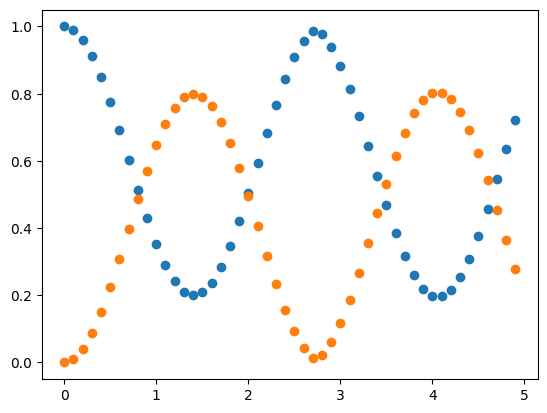

In [174]:
import matplotlib.pyplot as plt

P = np.zeros((len(epsilon), time.size))

counts = []
for nr, result in enumerate(results):
    for i in range(len(epsilon)):
        try:
            P[i, nr] = result[f'{1 << i:0{len(epsilon)}b}']
        except:
            P[i, nr] = 0

[plt.scatter(time[::10], P[i, ::10]) for i in range(len(epsilon))]